In [1]:
import matplotlib.pyplot as plt
import numpy as np
import helper
import time
import datetime
import torch.nn as nn
import torchvision.models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import torchvision.utils
import torch
import pandas as pd
from torchinfo import summary
from PIL import Image
from torchvision.transforms import ToTensor
from glob import glob
from torch.utils.data import Dataset, DataLoader, random_split
from copy import copy
from collections import defaultdict
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import time
from sklearn.metrics import classification_report
from tqdm import tqdm
import math
from torcheval.metrics import BinaryAccuracy
import os
import timm
import segmentation_models_pytorch as smp
import random
from sklearn.model_selection import train_test_split
from transformers import SegformerImageProcessor, AutoModelForSemanticSegmentation
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
batch_size=1
img_size=1024
class_list=['NT_epithelial', 'NT_immune', 'NT_stroma', 'TP_in_situ', 'TP_invasive']
tf = ToTensor()
def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result

2024-07-31 11:20:02.521725: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-31 11:20:03.357170: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
img_path='../../data/area_segmentation/BRDC/image/'
img_list=glob(img_path+'*.jpeg')
mask_list=[i.replace('/image','/mask') for i in img_list]
mask_list=[i.replace('.jpeg','.npy') for i in mask_list]
X_train, X_test, Y_train, Y_test = train_test_split(img_list, mask_list, test_size=0.2, random_state=321)
resize = torchvision.transforms.Resize(img_size)
test_image=torch.zeros((len(X_test),3,img_size,img_size))
test_mask=torch.zeros((len(Y_test),6,img_size,img_size),dtype=torch.float32)    
train_image=torch.zeros((len(X_train),3,img_size,img_size))
train_mask=torch.zeros((len(Y_train),6,img_size,img_size),dtype=torch.float32)

for i in tqdm(range(len(X_test))):
    test_image[i] = tf(Image.open(X_test[i]))
    test_mask[i,1:]=tf(np.load(Y_test[i]))/255.
    reverse_back=torch.where(test_mask[i,1:].sum(0)>0,1.,0.)
    test_mask[i,0]=1-reverse_back

100%|██████████| 113/113 [00:56<00:00,  2.00it/s]


In [3]:
class CustomDataset(Dataset):
    def __init__(self, image_list, label_list):
        self.img_path = image_list
        self.label = label_list
        
    def trans(self,image,label):
        if random.random() > 0.5:
            transform = transforms.RandomHorizontalFlip(1)
            label = transform(label)
            image = transform(image)
            
        if random.random() > 0.5:
            transform = transforms.RandomVerticalFlip(1)
            label = transform(label)
            image = transform(image)
            
        return image,label
    
    def __len__(self):
        return len(self.img_path)

    def __getitem__(self, idx):
        image_path,label_path = self.img_path[idx],self.label[idx]

        return image_path, label_path

test_dataset = CustomDataset(test_image, test_mask)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [4]:
model = smp.MAnet(
        encoder_name="efficientnet-b7",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=6,                      # model output channels (number of classes in your dataset) 
    ).to(device)
summary(model,(batch_size,3,img_size,img_size))
def dice_loss(pred, target, num_classes=4):
    smooth = 1e-6
    dice_per_class = torch.zeros((len(pred),num_classes)).to(pred.device)
    for i in range(len(pred)):
        for class_id in range(num_classes):
            pred_class = pred[i, class_id, ...]
            target_class = target[i, class_id, ...]
            
            intersection = torch.sum(pred_class * target_class)
            A_sum = torch.sum(pred_class * pred_class)
            B_sum = torch.sum(target_class * target_class)

            dice_per_class[i,class_id] =(2. * intersection + smooth) / (A_sum + B_sum + smooth)

    return 1-dice_per_class.mean()

model.load_state_dict(torch.load('../../model/areaSeg/model_callback.pt'))

<All keys matched successfully>

  0%|          | 0/113 [00:00<?, ?it/s]

 Step: 11 :   6%|▌         | 7/113 [00:00<00:05, 18.20it/s]

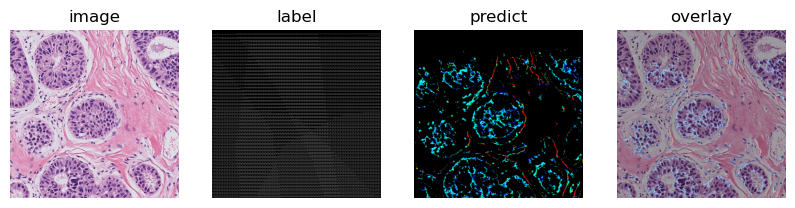

 Step: 21 :  17%|█▋        | 19/113 [00:01<00:06, 13.89it/s]

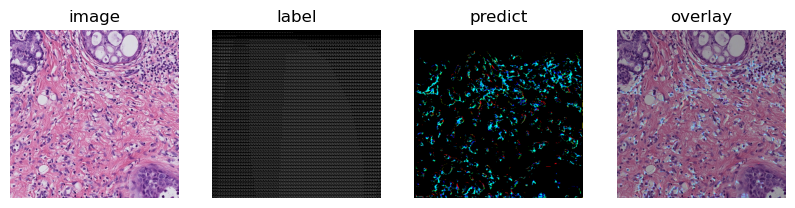

 Step: 31 :  24%|██▍       | 27/113 [00:02<00:09,  8.79it/s]

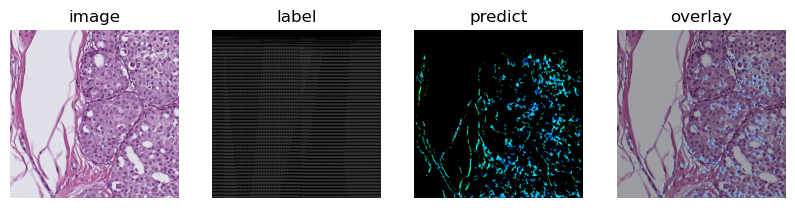

 Step: 41 :  34%|███▎      | 38/113 [00:04<00:07,  9.72it/s]

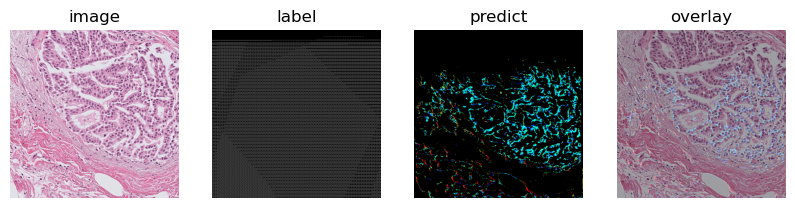

 Step: 51 :  42%|████▏     | 48/113 [00:05<00:06,  9.86it/s]

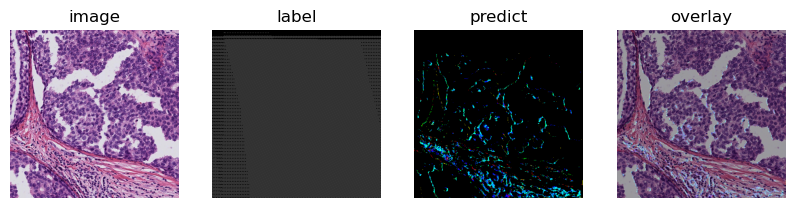

 Step: 61 :  52%|█████▏    | 59/113 [00:06<00:03, 14.94it/s]

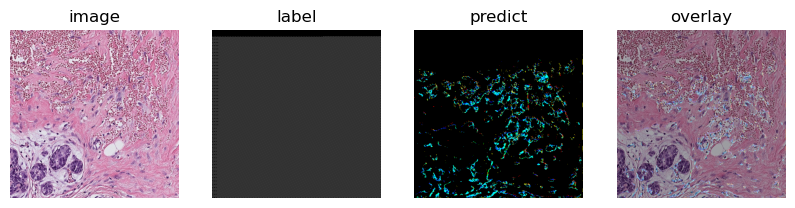

 Step: 71 :  60%|██████    | 68/113 [00:07<00:03, 14.61it/s]

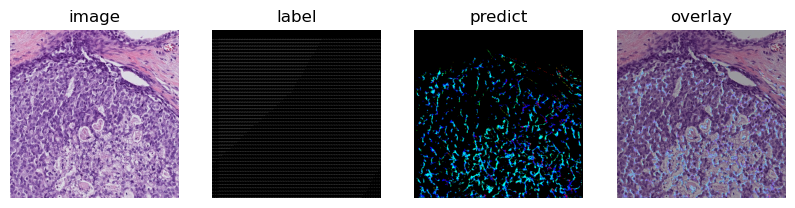

 Step: 81 :  68%|██████▊   | 77/113 [00:08<00:02, 13.77it/s]

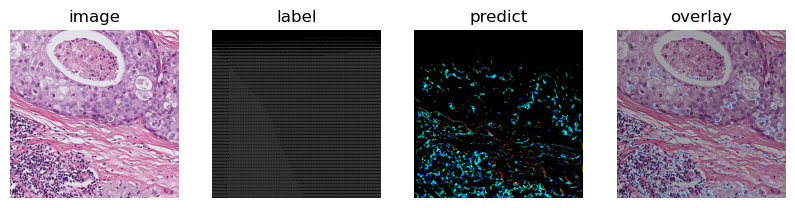

 Step: 91 :  77%|███████▋  | 87/113 [00:09<00:02, 11.42it/s]

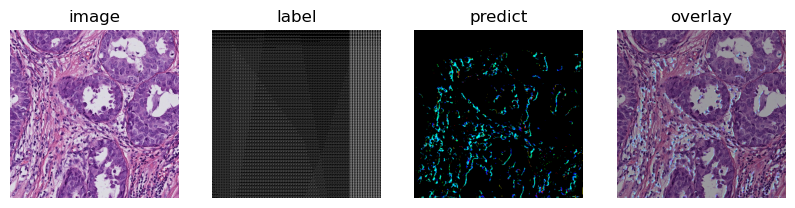

 Step: 101 :  88%|████████▊ | 99/113 [00:10<00:00, 15.23it/s]

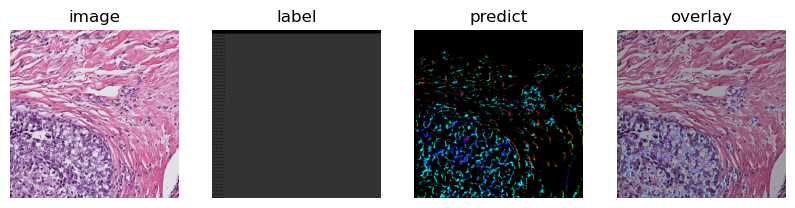

 Step: 111 :  96%|█████████▌| 108/113 [00:10<00:00, 14.07it/s]

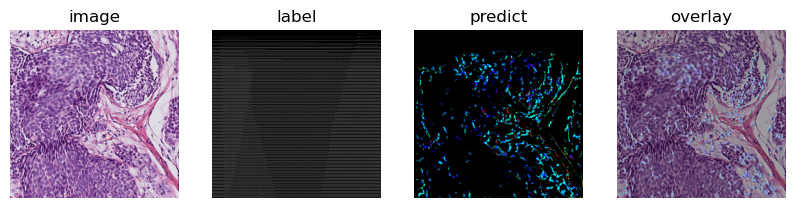

 Step: 114 : 100%|██████████| 113/113 [00:11<00:00,  9.87it/s]

batch size= 4
image size= 224
learning rate= 0.0001


In [5]:
topilimage = torchvision.transforms.ToPILImage()

train_loss_list=[]
val_loss_list=[]
train_acc_list=[]
val_acc_list=[]
MIN_loss=5000
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-4)
metrics = defaultdict(float)
val=tqdm(test_dataloader)
model.eval()
count=0
val_running_loss=0.0
acc_loss=0
with torch.no_grad():
    for x, y in val:
        y = y.to(device).float()
        count+=1
        x=x.to(device).float()
        predict = model(x).to(device)
        cost = dice_loss(predict, y).cpu().numpy()
        y = y.to('cpu')
        x=x.to('cpu')
        val.set_description(f" Step: {count+1} ")
        val_loss_list.append(1-cost)
        if count%10==0:
            pred_softmax = F.softmax(predict, dim=1).cpu()
            mask=torch.zeros((3,img_size,img_size))
            mask[0]=torch.where(pred_softmax.argmax(dim=1)==1,1,0)
            mask[1]=torch.where(pred_softmax.argmax(dim=1)==2,1,0)
            mask[2]=torch.where(pred_softmax.argmax(dim=1)==3,1,0)
            mask[0]+=torch.where(pred_softmax.argmax(dim=1)==4,1,0)[0]
            mask[1]+=torch.where(pred_softmax.argmax(dim=1)==4,1,0)[0]
            mask[1]+=torch.where(pred_softmax.argmax(dim=1)==5,1,0)[0]
            mask[2]+=torch.where(pred_softmax.argmax(dim=1)==5,1,0)[0]
            label=y[0,1:4]
            label[0]+=torch.where(y[0][4]==1,1,0)[0]
            label[1]+=torch.where(y[0][4]==1,1,0)[0]
            label[1]+=torch.where(y[0][5]==1,1,0)[0]
            label[2]+=torch.where(y[0][5]==1,1,0)[0]

            img=topilimage(x[0])
            label=topilimage(label)
            mask=topilimage(mask)
            overlay=np.array(img)*0.7+np.array(mask)*0.3
            overlay=Image.fromarray(overlay.astype('uint8'))
            fig = plt.figure(figsize=(10,30))
            rows = 1
            cols = 4
            ax1 = fig.add_subplot(rows, cols, 1)
            ax1.imshow(img)
            ax1.set_title('image')
            ax1.axis("off")
            
            ax2 = fig.add_subplot(rows, cols, 2)
            ax2.imshow(label)
            ax2.set_title('label')
            ax2.axis("off")
            
            ax3 = fig.add_subplot(rows, cols, 3)
            ax3.imshow(mask)
            ax3.set_title('predict')
            ax3.axis("off")
            
            ax4 = fig.add_subplot(rows, cols, 4)
            ax4.imshow(overlay)
            ax4.set_title('overlay')
            ax4.axis("off")
            plt.show()
           

print('batch size= 4')
print('image size= 224')
print('learning rate= 0.0001')

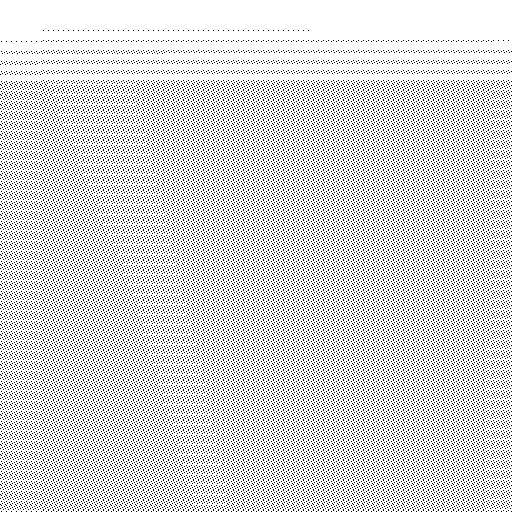

In [13]:
topilimage(y[0,0])

In [10]:
torch.where(pred_softmax.argmax(dim=1)==3,1,0).shape

torch.Size([1, 1024, 1024])

In [13]:
torch.where(pred_softmax.argmax(dim=1)==3,1,0)[0]

tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:4')

In [10]:
dice_score=np.array(val_loss_list)[:,0,1:]
except_dice_index=np.where(dice_score!=2)
index1=np.where(except_dice_index[1]==0)
print(f'1 Class DSC={dice_score[except_dice_index[0][index1[0]],except_dice_index[1][index1[0]]].mean()}')
index2=np.where(except_dice_index[1]==1)
print(f'2 Class DSC={dice_score[except_dice_index[0][index2[0]],except_dice_index[1][index2[0]]].mean()}')
index3=np.where(except_dice_index[1]==2)
print(f'3 Class DSC={dice_score[except_dice_index[0][index3[0]],except_dice_index[1][index3[0]]].mean()}')

1 Class DSC=0.6596973538398743
2 Class DSC=0.3544228672981262
3 Class DSC=0.21980944275856018
